In [ ]:
!pip install prophet tensorflow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

#tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def gen_url_resorce(base_url, resorce_pack, resource_id, year=0):
  if year !=0:
    resource_id = resource_id.replace("(year)", str(year))
  url = base_url + resorce_pack + resource_id
  return url

def resorce_in_year_interval(base_url, resorce_pack, resource_mask, start_year, end_year):
  df = pd.DataFrame()
  for year in range(start_year, end_year + 1):
    url = gen_url_resorce(base_url, resorce_pack, resource_mask, year)
    df_year = pd.read_csv(url, sep=';')
    df = pd.concat([df, df_year])
  return df

base_url =  "https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/"

# Recolhimento e Pre-processamento dos Dados
Endereços padronizados dos endpoints para coleta facilitada e contínua dos dados, permitindo consulta das bases de séries temporais anuais.

In [ ]:
#dados hidrológicos diários
resorce_pack_dh_di = "dados_hidrologicos_di/"
resource_mask_dh_di = "DADOS_HIDROLOGICOS_RES_(year).csv"

#dados diários de ENA por reservatório
resorce_pack_ena_di = 'ena_reservatorio_di/'
resource_mask_ena_di = "ENA_DIARIO_RESERVATORIOS_(year).csv"

#dados reservatórios
resource_pack_reservatorios = "reservatorio/"
resource_reservatorio_id = "RESERVATORIOS.csv"


Dados referentes a todos os reservatórios cadastrados, levando em consideração apenas instâncias únicas, nescessário devido a replicação dos dados entre os reservatórios P. Afonso 1, 2 e 3.

In [ ]:
resource_reservatorios_url = gen_url_resorce(base_url, resource_pack_reservatorios, resource_reservatorio_id,)
reservatorios = pd.read_csv(resource_reservatorios_url, sep=';')
#remover duplicatas
reservatorios = reservatorios.drop_duplicates(subset=['cod_resplanejamento'])
reservatorios.head()

,nom_reservatorio,tip_reservatorio,cod_resplanejamento,cod_posto,nom_usina,ceg,id_subsistema,nom_subsistema,nom_bacia,nom_rio,...,val_volmax,val_volmin,val_volutiltot,val_produtibilidadeespecifica,val_produtividade65volutil,val_tipoperda,val_perda,val_latitude,val_longitude,id_reservatorio
0,14 DE JULHO,FIO DAGUA,99,284,14 DE JULHO,UHE.PH.RS.000012-4.01,S,SUL,JACUI,TAQUARI-ANTAS,...,55.18,50.47,4.71,0.008927,0.3016,m,0.74,-29.069444,-51.675278,JIUHQJ
1,A. VERMELHA,RESERVATÓRIO COM USINA,18,18,ÁGUA VERMELHA,UHE.PH.MG.000041-8.01,SE,SUDESTE/CENTRO-OESTE,GRANDE,GRANDE,...,11025.00,5856.00,5169.22,0.008825,0.4625,m,0.75,-19.868056,-50.342778,GRAGVL
2,AIMORES,FIO DAGUA,143,148,AIMORÉS,UHE.PH.MG.000042-6.01,SE,SUDESTE/CENTRO-OESTE,DOCE,DOCE,...,185.52,156.55,12.14,0.008926,0.2558,m,0.32,-19.453333,-41.096667,DCAIMO
3,ANTA,RESERVATÓRIO SEM USINA,128,129,ANTA,UHE.PH.MG.029458-6.01,SE,SUDESTE/CENTRO-OESTE,PARAIBA DO SUL,PARAÍBA SUL,...,74.25,63.89,10.36,NaN,NaN,NaN,NaN,-22.033333,-43.000000,PBANTA
4,APOLONIO SALES,FIO DAGUA,173,173,APOLÔNIO SALES,UHE.PH.AL.001510-5.01,NE,NORDESTE,SAO FRANCISCO,SÃO FRANCISCO,...,1226.00,1226.00,209.00,0.008973,0.0974,m,0.22,-9.356111,-38.210278,SFMOXO


Consulta e concatenação dos dados diários de Energia Natural Afluente (ENA) por reservatório no período de 2021 a 2025. Esse intervalo foi escolhido devido à proximidade temporal com eventos climáticos significativos, que impactaram diretamente a disponibilidade hídrica na região, como a eventos de seca e cheias recentes. Como pode ser notado nas seguintes notícias.

https://cbhsaofrancisco.org.br/noticias/novidades/mesmo-com-dois-anos-consecutivos-de-cheia-os-problemas-da-bacia-do-sao-francisco-nao-devem-ser-minimizados/

https://manguejornalismo.org/rio-sao-francisco-esta-secando-pesquisa-alerta-que-60-de-sua-vazao-ja-foi-reduzida/


In [ ]:
resorce_ena_di_interval = resorce_in_year_interval(base_url, resorce_pack_ena_di, resource_mask_ena_di, 2021, 2025)
#exibir not numbers
resorce_ena_di_interval = resorce_ena_di_interval[~pd.to_numeric(resorce_ena_di_interval['cod_resplanejamento'], errors='coerce').isna()]
resorce_ena_di_interval['cod_resplanejamento'] = resorce_ena_di_interval['cod_resplanejamento'].astype(int)
print(resorce_ena_di_interval.isnull().sum())
resorce_ena_di_interval.head()

nom_reservatorio                        0
cod_resplanejamento                     0
tip_reservatorio                        0
nom_bacia                               0
nom_ree                               858
id_subsistema                           0
nom_subsistema                          0
ena_data                                0
ena_bruta_res_mwmed                  1834
ena_bruta_res_percentualmlt          1834
ena_armazenavel_res_mwmed            1834
ena_armazenavel_res_percentualmlt    1834
ena_queda_bruta                      1834
mlt_ena                              1834
dtype: int64


,nom_reservatorio,cod_resplanejamento,tip_reservatorio,nom_bacia,nom_ree,id_subsistema,nom_subsistema,ena_data,ena_bruta_res_mwmed,ena_bruta_res_percentualmlt,ena_armazenavel_res_mwmed,ena_armazenavel_res_percentualmlt,ena_queda_bruta,mlt_ena
0,14 DE JULHO,99,Fio dagua,JACUI,SUL,S,SUL,2021-01-01,29.563,58.0003,29.563,58.0003,29.235,50.9704
1,A. VERMELHA,18,Reservatório com Usina,GRANDE,PARANA,SE,SUDESTE,2021-01-01,1257.339,75.8953,1257.339,75.8953,1146.212,1656.6750
2,AIMORES,143,Fio dagua,DOCE,SUDESTE,SE,SUDESTE,2021-01-01,150.234,38.0876,146.141,37.0499,150.665,394.4436
3,B. BONITA,37,Reservatório com Usina,TIETE,PARANA,SE,SUDESTE,2021-01-01,109.679,90.1550,104.528,85.9210,106.515,121.6560
4,B.COQUEIROS,312,Fio dagua,PARANAIBA,PARANA,SE,SUDESTE,2021-01-01,46.519,49.2308,29.164,30.8641,47.004,94.4916


Porque a estação do ano influencia diretamente o regime de chuvas e, consequentemente, o volume dos reservatórios, sendo essencial para capturar padrões sazonais na previsão de ENA.

In [ ]:
def get_season_by_date(date):
    month = date.month
    if month in [12, 1, 2]:
        return 1 #verão
    elif month in [3, 4, 5]:
        return 2 #Outono
    elif month in [6, 7, 8]:
        return 3 #inverno
    elif month in [9, 10, 11]:
        return 4 # primavera
    else:
        return 0

Cruza os dados das duas bases de dados permitindo a comparação de séries temporais.

In [ ]:
def merge_ena_di_reservatorios(df_ena_di, reservatorios):
  df_ena_di_reservatorios = pd.merge(df_ena_di, reservatorios, on='cod_resplanejamento', how='left')
  return df_ena_di_reservatorios

Prepara os dados para treinamento filtrando por reservatório e levanto em consideração as features de maior relevância encontradas, sendo elas ENA, (nosso objetivo de predição), a data da coleta do dado(relevante para o estudo da série temporal no modelo Prophet) e a partir desta ano, mes e dia da coleta, o volume d'água calculado sobre o valor de ENA e a produtividade específica de cada reservatório e a estação do ano no hemisfério sul.

In [ ]:
def prepare_ena_di_reservatorio(df, rese):
  df_ena_di = df.copy()
  df_ena_di = df_ena_di[df_ena_di['cod_resplanejamento'] == rese]
  df_ena_di['ena_data'] = pd.to_datetime(df_ena_di['ena_data'])
  df_ena_di = df_ena_di.rename(columns={'ena_data': 'ds', 'ena_bruta_res_mwmed': 'y'})
  df_ena_di['vol_calc'] = df_ena_di['y'] / df_ena_di['val_produtibilidadeespecifica']
  df_ena_di['season'] = df_ena_di['ds'].apply(get_season_by_date)
  df_ena_di['year'] = df_ena_di['ds'].dt.year
  df_ena_di['month'] = df_ena_di['ds'].dt.month
  df_ena_di['day'] = df_ena_di['ds'].dt.day
  df_ena_di = df_ena_di[['ds', 'y', 'vol_calc', 'season', 'year', 'month', 'day']]
  return df_ena_di

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

def plot_acf_pacf(df, column):
  plt.figure(figsize=(14, 6))
  plt.subplot(1, 2, 1)
  plot_acf(df['y'].dropna(), ax=plt.gca(), lags=365)
  plt.title('Função de Autocorrelação (ACF) da ENA')

  plt.subplot(1, 2, 2)
  plot_pacf(df['y'].dropna(), ax=plt.gca(), lags=365)
  plt.title('Função de Autocorrelação Parcial (PACF) da ENA')

  plt.tight_layout()
  plt.show()


In [ ]:
def normalize_columns(df):
  df_norm = df.copy()
  for col in df.columns:
    if col != 'ds' and col != 'season':
      df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
  return df_norm

# Treinamento e Teste do Modelo Prophet
O Prophet é uma biblioteca desenvolvida pelo Facebook (agora Meta) para previsão de séries temporais, especialmente quando há tendências não lineares e forte sazonalidade, sendo fácil de usar e interpretar.

Após o treinamento do modelo, é essencial avaliar sua performance e interpretar os resultados. Para isso, foram implementadas funções auxiliares que calculam métricas de erro e geram visualizações do ajuste e da decomposição dos componentes previstos.

As métricas utilizadas são:

* MAE (Erro Médio Absoluto): mede o desvio médio entre valores reais e previstos.

* RMSE (Raiz do Erro Quadrático Médio): penaliza mais fortemente erros grandes, útil para avaliar robustez do modelo.

* MAPE (Erro Percentual Médio Absoluto): expressa o erro em termos percentuais, facilitando a interpretação relativa ao valor real.

Além das métricas, também são gerados gráficos do forecast (previsão em relação aos dados reais) e dos componentes do modelo (tendência, sazonalidade anual/semanal e possíveis efeitos de feriados).

Essas ferramentas permitem não apenas quantificar o desempenho do modelo, mas também compreender melhor o comportamento temporal da série de ENA em cada reservatório analisado.

In [ ]:
def avalute_prophet_model(performance):

  performance['error'] = performance['y'] - performance['yhat']
  performance['absolute_error'] = performance['error'].abs()

  mae = performance['absolute_error'].mean()
  rmse = (performance['error']**2).mean()**0.5

  epsilon = 1e-10
  mape = np.mean(np.abs((performance['y'] - performance['yhat']) / (performance['y'] + epsilon))) * 100

  print("### Métricas de Avaliação do Modelo ###")
  print(f"Erro Médio Absoluto (MAE): {mae:.2f} MWméd")
  print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} MWméd")
  print(f"Erro Percentual Médio Absoluto (MAPE): {mape:.2f}%")

  real_mean = performance['y'].mean()
  print(f"\nContexto: O valor médio real de ENA no período foi de {real_mean:.2f} MWméd.")
  print(f"Um erro (MAE) de {mae:.2f} representa aproximadamente {(mae/real_mean*100):.2f}% do valor médio.")

  return mae, rmse, mape

def plot_forecast(model, forecast, test_data, rese):
  fig1 = model.plot(forecast, xlabel='Date', ylabel='ENA (Normalized)')
  fig1.gca().set_title(f'Forecast for {rese}')
  fig1.gca().plot(test_data['ds'], test_data['y'], 'o', color='red', markersize=2, label='Real')
  fig1.gca().legend()
  fig1.gca().title.set_text(f'Forecast for {rese}')
  plt.savefig(f'{rese}_forecast.png')
  plt.show()

  fig2 = model.plot_components(forecast)
  fig2.gca().set_title(f'Forecast Components for {rese}')
  plt.savefig(f'{rese}_forecast_components.png')
  plt.show()

A função **`train_prophet_model`** treina e testa um modelo Prophet para previsão de séries temporais.

* Normaliza os dados de entrada
* Divide em treino (datas < `limit_date`) e teste (datas ≥ `limit_date`)
* Ajusta o modelo Prophet com os dados de treino
* Gera previsões para o período de teste
* Avalia a performance com métricas (MAE, RMSE, MAPE)
* Plota gráficos de previsão e componentes
* Exporta resultados em CSV e retorna um DataFrame com valores reais e previstos


In [ ]:
def train_prophet_model(rese_data, rese, limit_date='2025-01-01'):
  y_min = rese_data['y'].min()
  y_max = rese_data['y'].max()
  data = rese_data.copy()
  scaled = normalize_columns(rese_data)
  df_scaled = scaled.copy()
  df_scaled['ds'] = scaled['ds'].values

  train_data = df_scaled[df_scaled['ds'] < limit_date]
  test_data = df_scaled[df_scaled['ds'] >= limit_date]

  m = Prophet()
  m.fit(train_data)

  periods = len(test_data)
  future = m.make_future_dataframe(periods=periods)

  forecast = m.predict(future)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  performance = pd.merge(rese_data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

  avalute_prophet_model(performance)

  plot_forecast(m,forecast, test_data, rese)

  df_prev = pd.DataFrame({'ds': data[data['ds'] >= limit_date]['ds'], 'ena_di': test_data['y'], 'ena_di_prev': forecast['yhat'], 'rese': rese })
  print(df_prev)
  df_prev.to_csv(f'{rese}_prophet_prev.csv', index=False)
  return df_prev

# Treinamento e Teste do Modelo de LSTM

O código abaixo apresenta funções auxiliares para treinar e avaliar um modelo LSTM na previsão da ENA diária. Elas incluem a criação de janelas temporais da série, a definição da arquitetura da rede (duas camadas LSTM, dropout e saída densa), a plotagem dos resultados reais vs. previstos e o cálculo de métricas de desempenho como MAE, MSE, RMSE, R² e MAPE.

In [ ]:

def create_sequences(data, target_col, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_col])
    return np.array(X), np.array(y)

def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1))
    return model

def plot_lstm_results(rese, dates_test, y_test_inv, y_pred_inv):
  plt.figure(figsize=(12,5))
  plt.plot(dates_test, y_test_inv, label="Real", color="blue")
  plt.plot(dates_test, y_pred_inv, label="Previsto", color="red")
  plt.xlabel("Data")
  plt.ylabel("ENA (MWmed)")
  plt.title(f"Previsão LSTM - ENA diária de {rese}")
  plt.legend()
  plt.savefig(f'{rese}_lstm_results.png')
  plt.show()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # evitar divisão por zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def avalute_lstm_model(y_test_inv, y_pred_inv):
  mae = mean_absolute_error(y_test_inv, y_pred_inv)
  mse = mean_squared_error(y_test_inv, y_pred_inv)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test_inv, y_pred_inv)
  mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  print(f"MAE: {mae:.2f}")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R²: {r2:.2f}")
  print(f"MAPE: {mape:.2f}%")

A função treina um modelo LSTM para prever a ENA diária de um reservatório. Primeiro, normaliza os dados e cria janelas temporais para capturar o histórico recente. Divide os dados entre treino e teste, ajusta a rede LSTM e salva o modelo. Em seguida, faz previsões, reverte a normalização e registra os valores reais e previstos em um CSV. Por fim, avalia o desempenho com métricas e plota os resultados para visualização.

In [ ]:
def train_lstm_model(rese_data, rese):
  df_ena = rese_data.copy()

  scaler = MinMaxScaler()
  cols  = ['y', 'vol_calc', 'month', 'day']
  scaled = scaler.fit_transform(df_ena[cols])

  df_scaled = pd.DataFrame(scaled, columns=cols)
  df_scaled['ds'] = df_ena['ds'].values

  # Converter para numpy
  data = df_scaled[cols].values

  # Usando coluna 0 (y = ENA) como alvo
  window_size = 30
  X, y = create_sequences(data, target_col=0, window_size=window_size)
  dates_y = df_ena['ds'].values[window_size:]
  print("Shape X:", X.shape)  # (amostras, janela, features)
  print("Shape y:", y.shape)

  split = int(0.8 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  dates_train, dates_test = dates_y[:split], dates_y[split:]

  model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
  model.compile(optimizer='adam', loss='mse')
  history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test))
  model.save(f'{rese}_model.keras')

  y_pred = model.predict(X_test)

  y_test_inv = scaler.inverse_transform(
      np.hstack((y_test.reshape(-1,1),
                X_test[:, -1, 1:]))  # mantém features vol_calc, month, day
  )[:,0]

  y_pred_inv = scaler.inverse_transform(
      np.hstack((y_pred, X_test[:, -1, 1:]))
  )[:,0]

  df_prev = pd.DataFrame({'ds': dates_test, 'ena_di': y_test_inv, 'ena_di_prev': y_pred_inv, 'rese': rese })
  df_prev.to_csv(f'{rese}_lstm_prev.csv', index=False)

  avalute_lstm_model(y_test_inv, y_pred_inv)
  plot_lstm_results(rese, dates_test, y_test_inv, y_pred_inv)
  return df_prev






Esse trecho de código realiza o processamento e treinamento automático para cada bacia do Rio São Francisco. De forma prosaica:

Ele começa mesclando os dados de ENA diária com os reservatórios. Em seguida, define um dicionário com os principais reservatórios do Rio São Francisco, incluindo seus códigos e nomes. Para cada bacia, o código:

* Imprime o nome da bacia atual.

* Prepara os dados específicos da bacia chamando prepare_ena_di_reservatorio.

* Analisa a autocorrelação e autocorrelação parcial da série com plot_acf_pacf.

* Treina o modelo Prophet para prever a ENA diária.

* Treina o modelo LSTM para prever a ENA diária.

Reservatório: SOBRADINHO


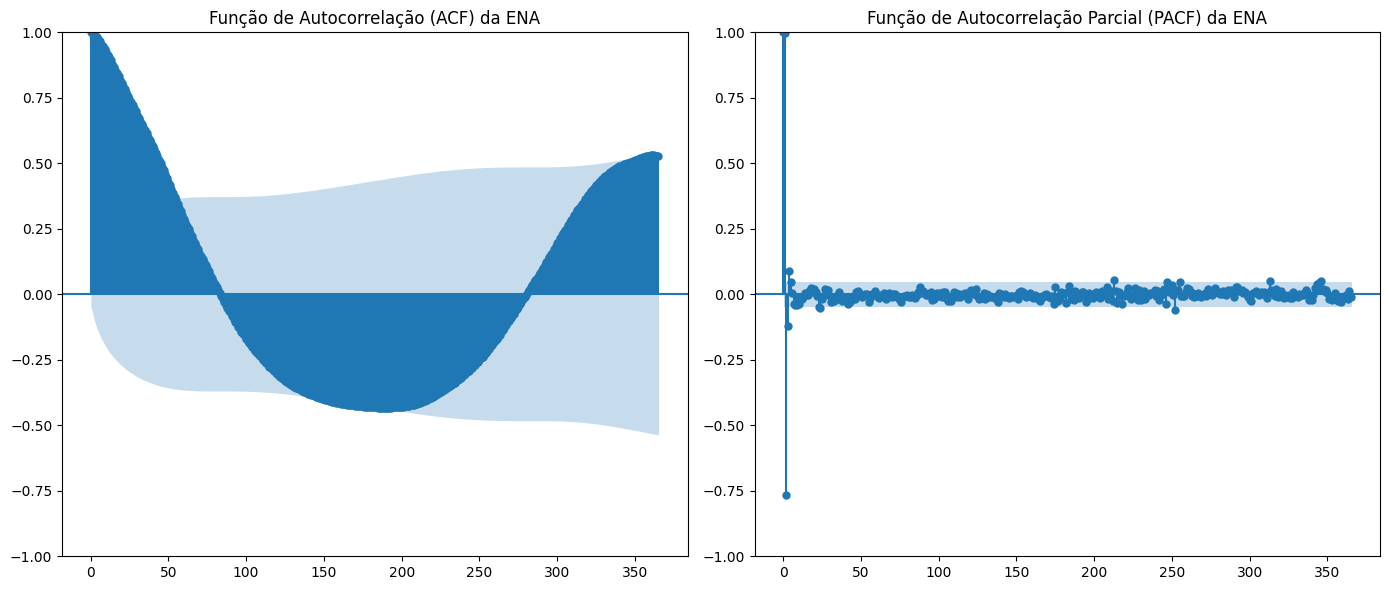

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/nzhm7ei5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/r79okrb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62641', 'data', 'file=/tmp/tmp20qzy7c_/nzhm7ei5.json', 'init=/tmp/tmp20qzy7c_/r79okrb8.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_model_1_u0hal/prophet_model-20250925104626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 414.65 MWméd
Raiz do Erro Quadrático Médio (RMSE): 573.12 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.95%

Contexto: O valor médio real de ENA no período foi de 414.85 MWméd.
Um erro (MAE) de 414.65 representa aproximadamente 99.95% do valor médio.


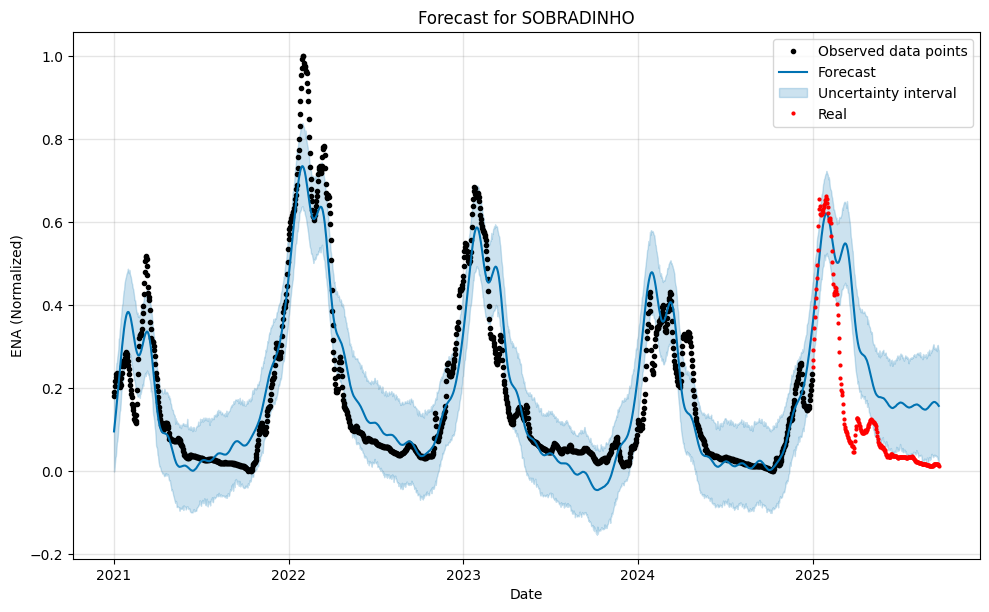

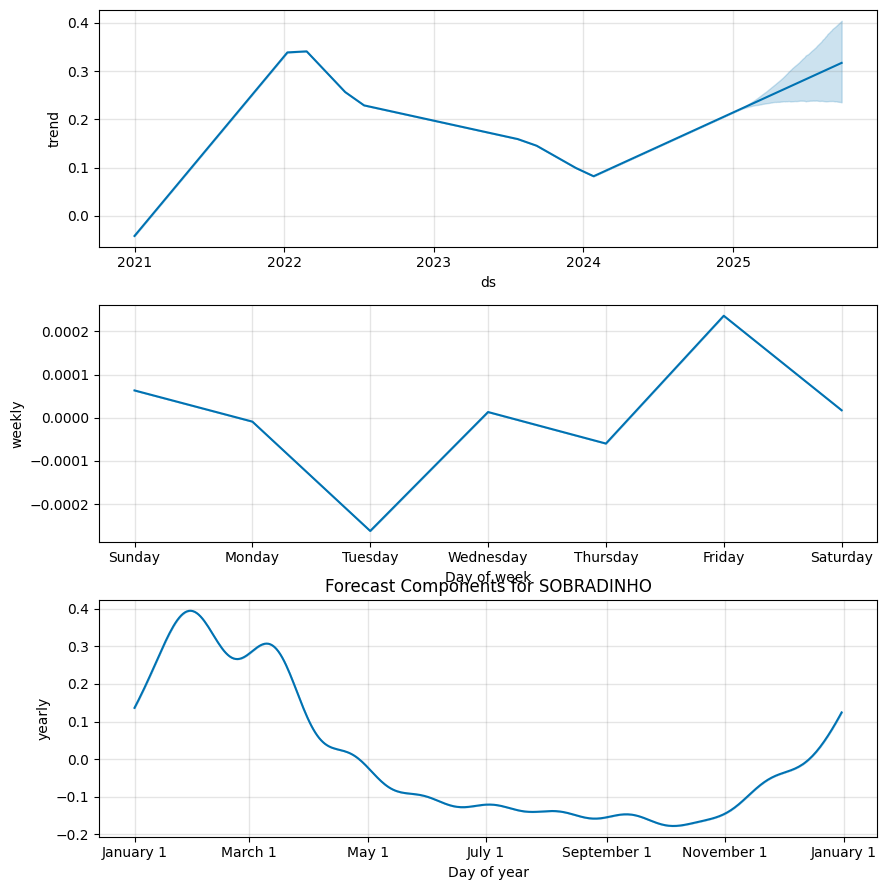

               ds    ena_di  ena_di_prev        rese
0             NaT       NaN     0.095206  SOBRADINHO
1             NaT       NaN     0.105983  SOBRADINHO
2             NaT       NaN     0.117240  SOBRADINHO
3             NaT       NaN     0.128593  SOBRADINHO
4             NaT       NaN     0.139977  SOBRADINHO
...           ...       ...          ...         ...
261423 2025-09-18  0.016570          NaN  SOBRADINHO
261578 2025-09-19  0.016645          NaN  SOBRADINHO
261733 2025-09-20  0.013180          NaN  SOBRADINHO
261888 2025-09-21  0.015481          NaN  SOBRADINHO
262043 2025-09-22  0.012446          NaN  SOBRADINHO

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0155 - val_loss: 0.0034
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 9.5085e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 7.7828e-04
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 7.1550e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 7.3473e-04
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - val_loss: 7.2189e-04
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 6.9258e-04
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.2090e-04 - val_loss: 9.9078e-04
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 

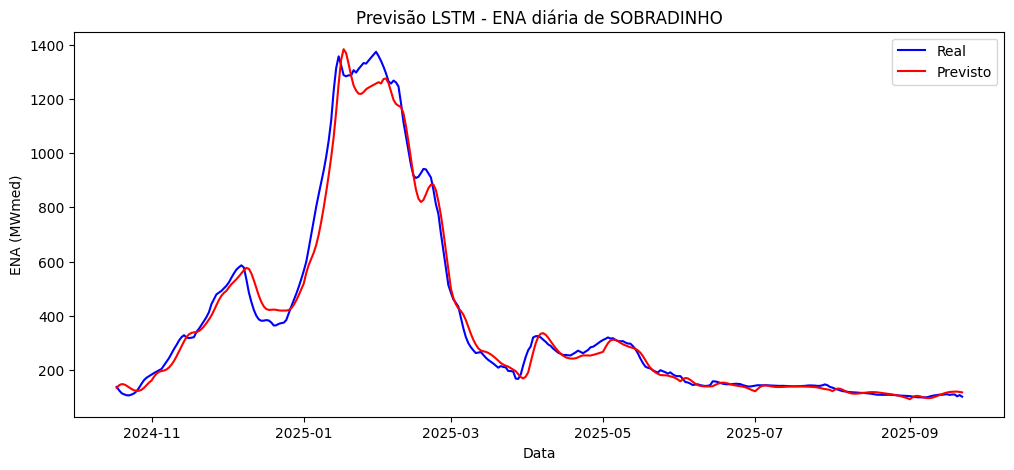

Reservatório: P. AFONSO 1,2,3


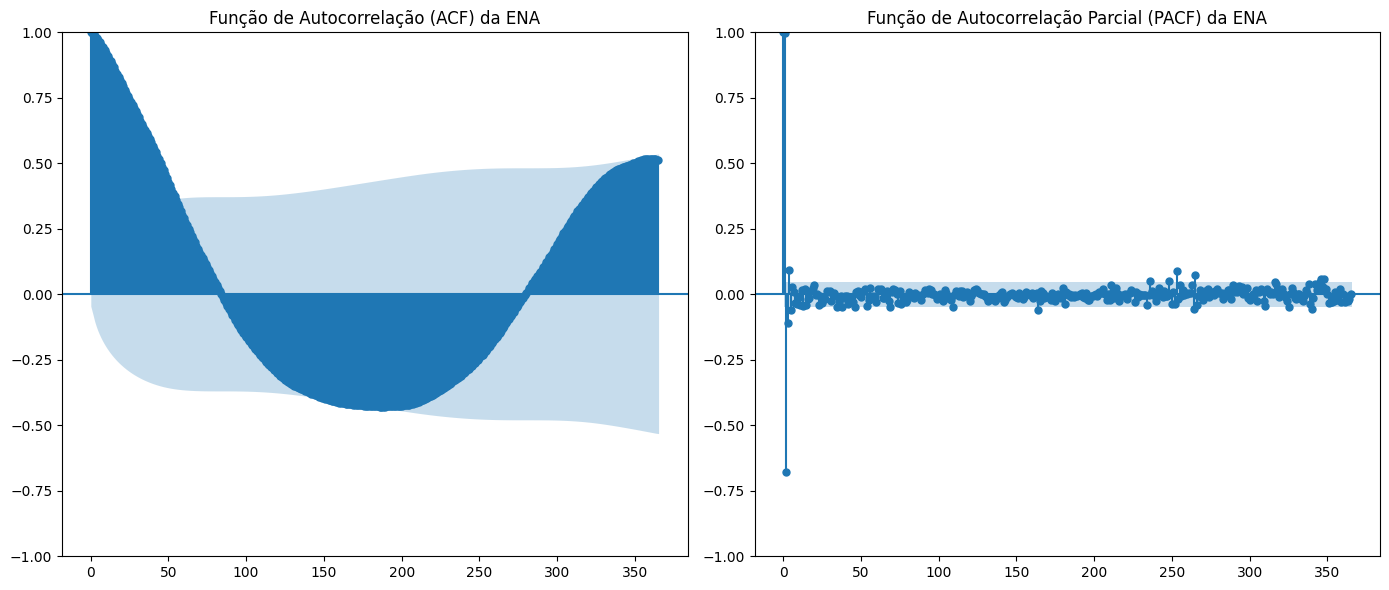

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/si09brvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/ujvmi__x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92195', 'data', 'file=/tmp/tmp20qzy7c_/si09brvw.json', 'init=/tmp/tmp20qzy7c_/ujvmi__x.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_modelecd966zk/prophet_model-20250925104710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:47:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:47:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 658.13 MWméd
Raiz do Erro Quadrático Médio (RMSE): 914.26 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.97%

Contexto: O valor médio real de ENA no período foi de 658.32 MWméd.
Um erro (MAE) de 658.13 representa aproximadamente 99.97% do valor médio.


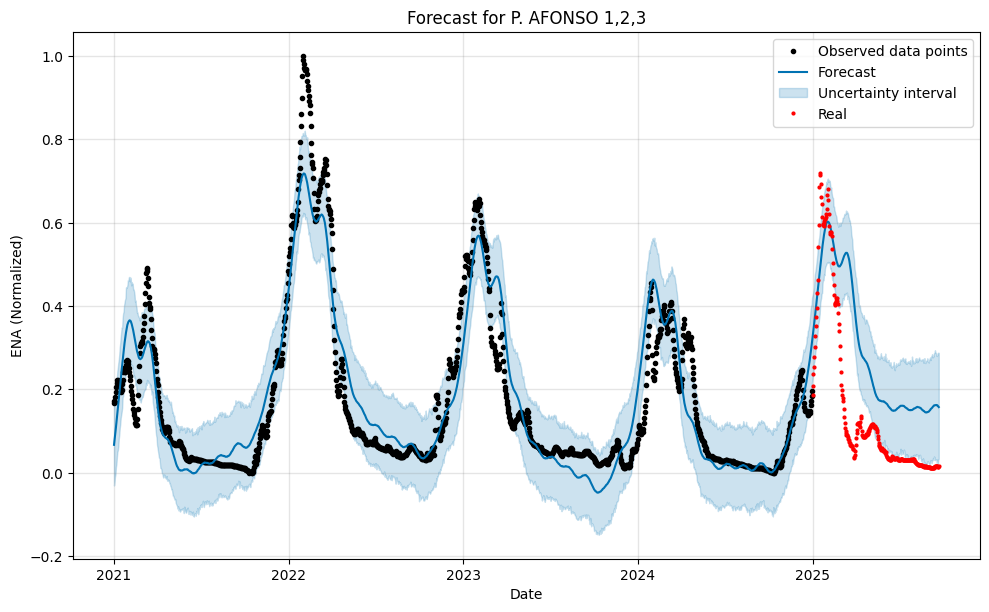

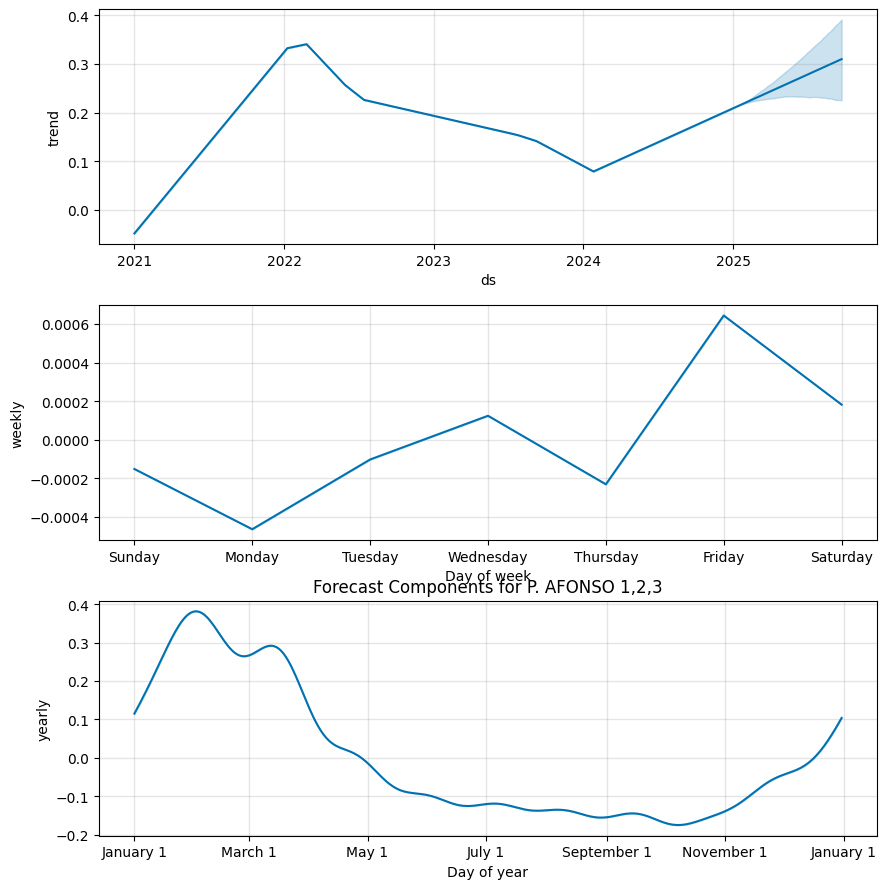

               ds    ena_di  ena_di_prev             rese
0             NaT       NaN     0.067210  P. AFONSO 1,2,3
1             NaT       NaN     0.077092  P. AFONSO 1,2,3
2             NaT       NaN     0.087255  P. AFONSO 1,2,3
3             NaT       NaN     0.097589  P. AFONSO 1,2,3
4             NaT       NaN     0.108742  P. AFONSO 1,2,3
...           ...       ...          ...              ...
261375 2025-09-18  0.016127          NaN  P. AFONSO 1,2,3
261530 2025-09-19  0.015383          NaN  P. AFONSO 1,2,3
261685 2025-09-20  0.013675          NaN  P. AFONSO 1,2,3
261840 2025-09-21  0.013365          NaN  P. AFONSO 1,2,3
261995 2025-09-22  0.015318          NaN  P. AFONSO 1,2,3

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0180 - val_loss: 0.0042
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.5350e-04 - v

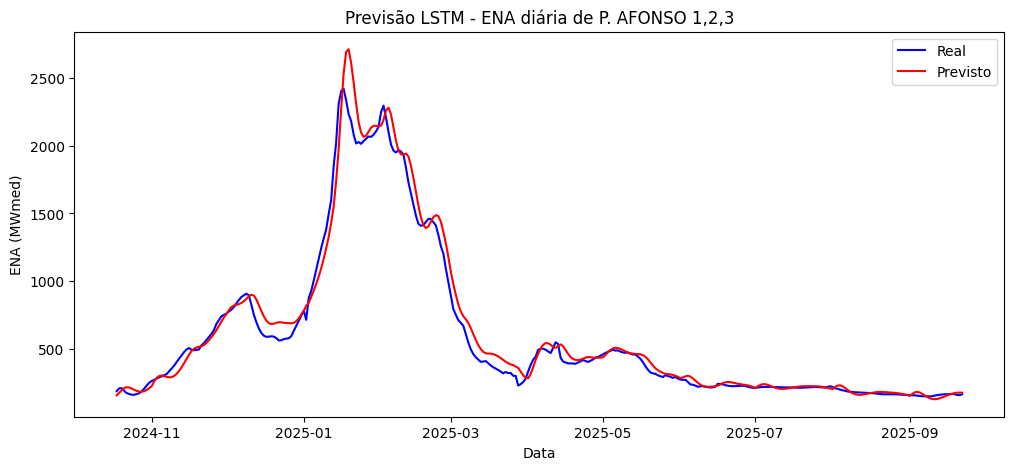

Reservatório: LUIZ GONZAGA


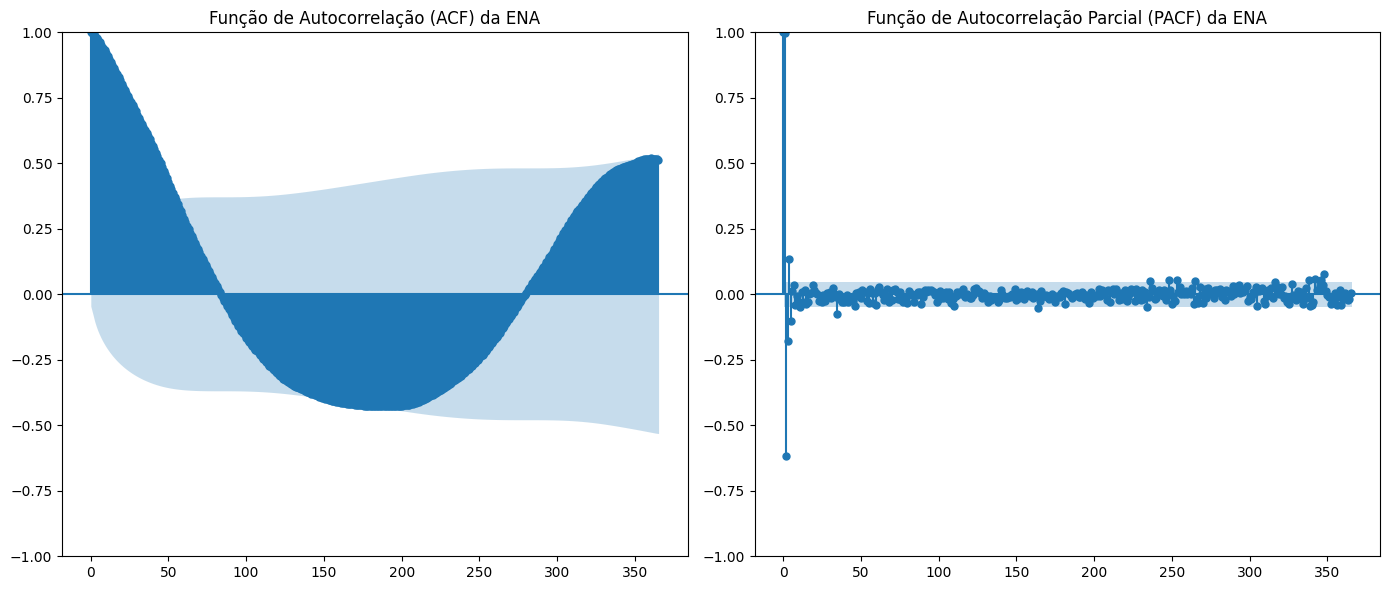

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/vkyu3bft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/o7iz84ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53679', 'data', 'file=/tmp/tmp20qzy7c_/vkyu3bft.json', 'init=/tmp/tmp20qzy7c_/o7iz84ts.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_modelfpenys9w/prophet_model-20250925104757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 766.35 MWméd
Raiz do Erro Quadrático Médio (RMSE): 1064.74 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.98%

Contexto: O valor médio real de ENA no período foi de 766.53 MWméd.
Um erro (MAE) de 766.35 representa aproximadamente 99.98% do valor médio.


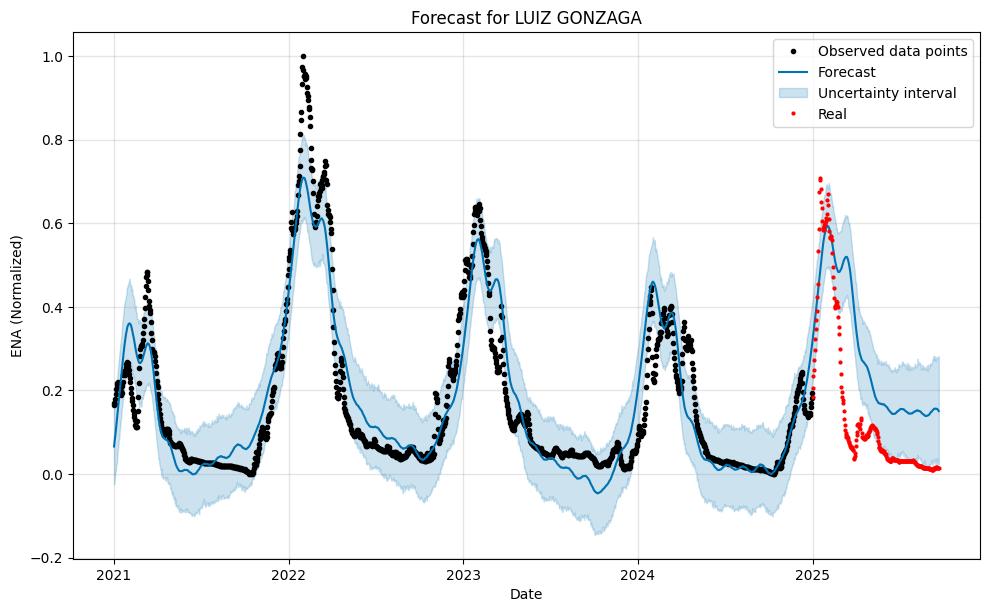

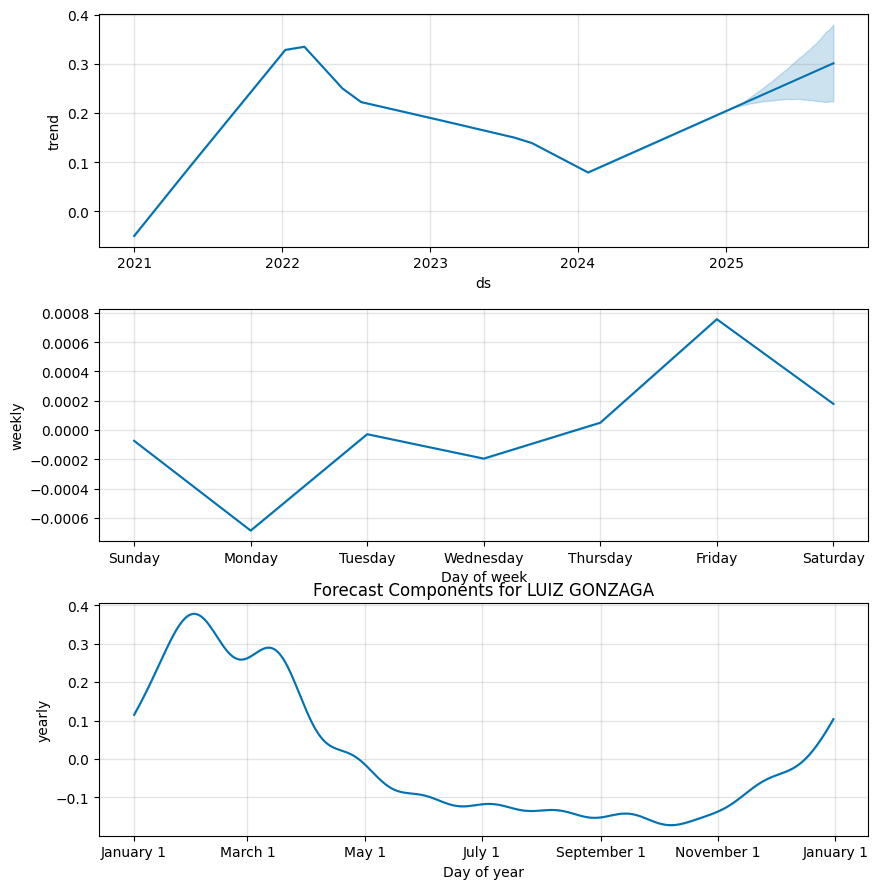

               ds    ena_di  ena_di_prev          rese
0             NaT       NaN     0.065570  LUIZ GONZAGA
1             NaT       NaN     0.075106  LUIZ GONZAGA
2             NaT       NaN     0.085138  LUIZ GONZAGA
3             NaT       NaN     0.094980  LUIZ GONZAGA
4             NaT       NaN     0.106265  LUIZ GONZAGA
...           ...       ...          ...           ...
261362 2025-09-18  0.015870          NaN  LUIZ GONZAGA
261517 2025-09-19  0.015138          NaN  LUIZ GONZAGA
261672 2025-09-20  0.013457          NaN  LUIZ GONZAGA
261827 2025-09-21  0.013152          NaN  LUIZ GONZAGA
261982 2025-09-22  0.015074          NaN  LUIZ GONZAGA

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0461 - val_loss: 0.0048
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.6050e-04 - v

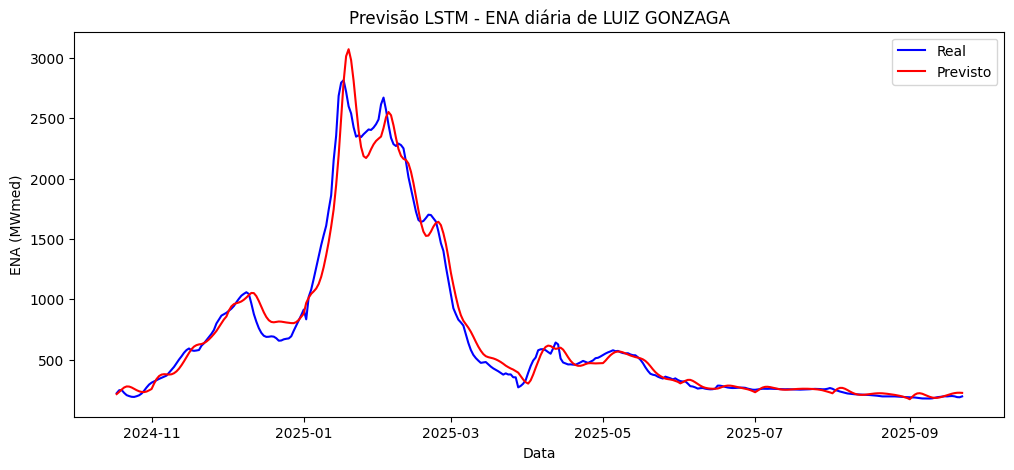

Reservatório: XINGO


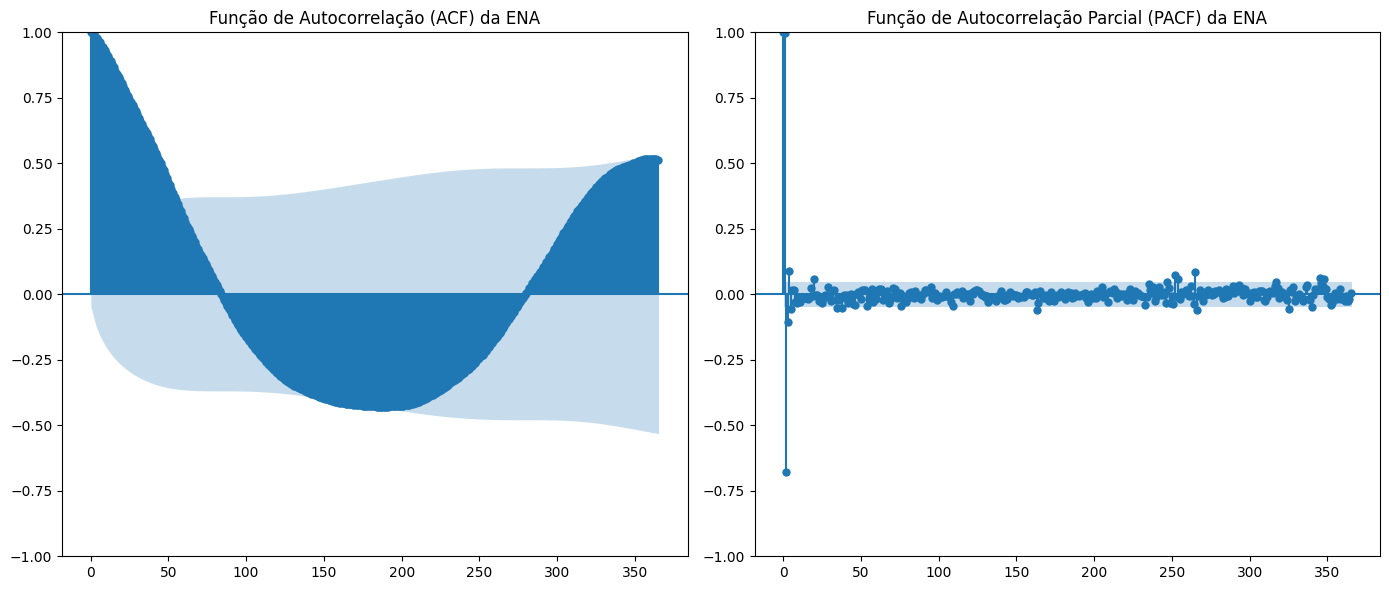

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/sz0vn37o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/5xroyv1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59885', 'data', 'file=/tmp/tmp20qzy7c_/sz0vn37o.json', 'init=/tmp/tmp20qzy7c_/5xroyv1x.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_model5v4ttr39/prophet_model-20250925104845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:48:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 1868.09 MWméd
Raiz do Erro Quadrático Médio (RMSE): 2594.35 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.99%

Contexto: O valor médio real de ENA no período foi de 1868.28 MWméd.
Um erro (MAE) de 1868.09 representa aproximadamente 99.99% do valor médio.


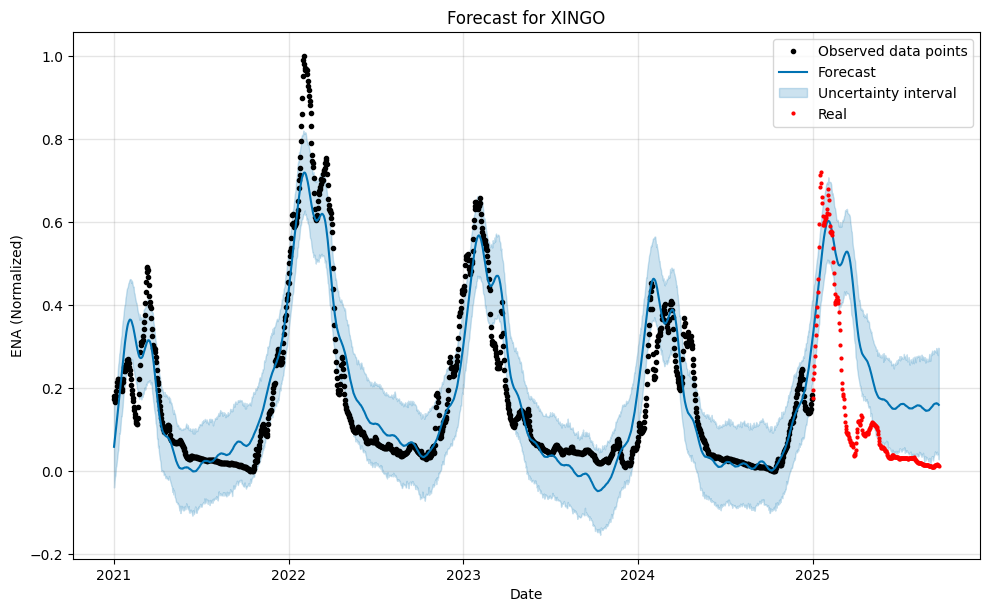

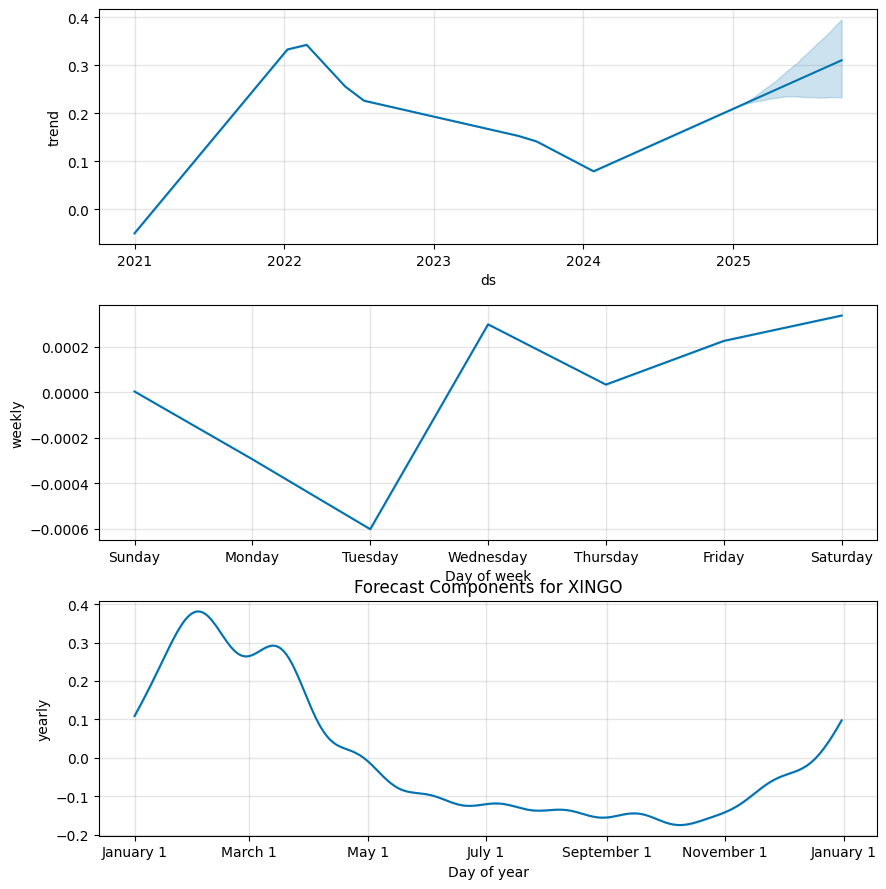

               ds    ena_di  ena_di_prev   rese
0             NaT       NaN     0.058699  XINGO
1             NaT       NaN     0.069019  XINGO
2             NaT       NaN     0.079022  XINGO
3             NaT       NaN     0.089184  XINGO
4             NaT       NaN     0.099456  XINGO
...           ...       ...          ...    ...
261434 2025-09-18  0.015884          NaN  XINGO
261589 2025-09-19  0.016127          NaN  XINGO
261744 2025-09-20  0.013956          NaN  XINGO
261899 2025-09-21  0.013675          NaN  XINGO
262054 2025-09-22  0.013246          NaN  XINGO

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0299 - val_loss: 0.0040
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011 - val_l

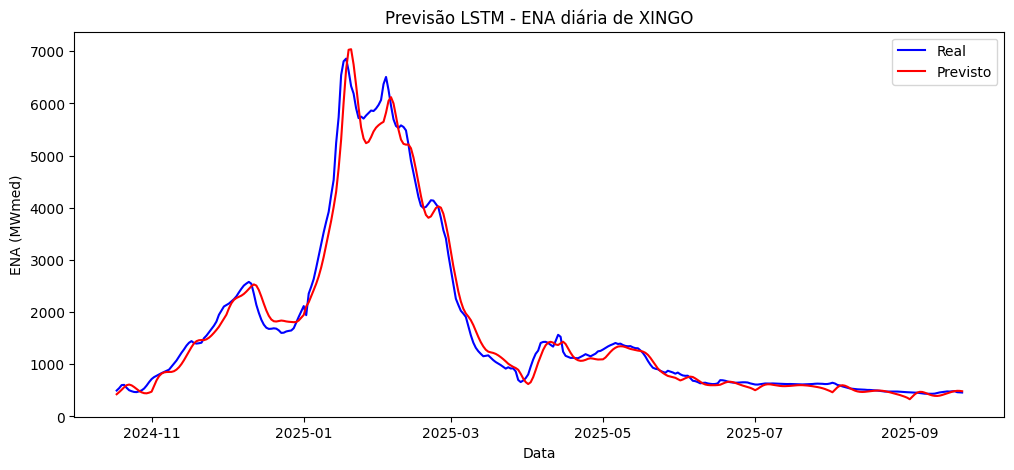

Reservatório: TRÊS MARIAS


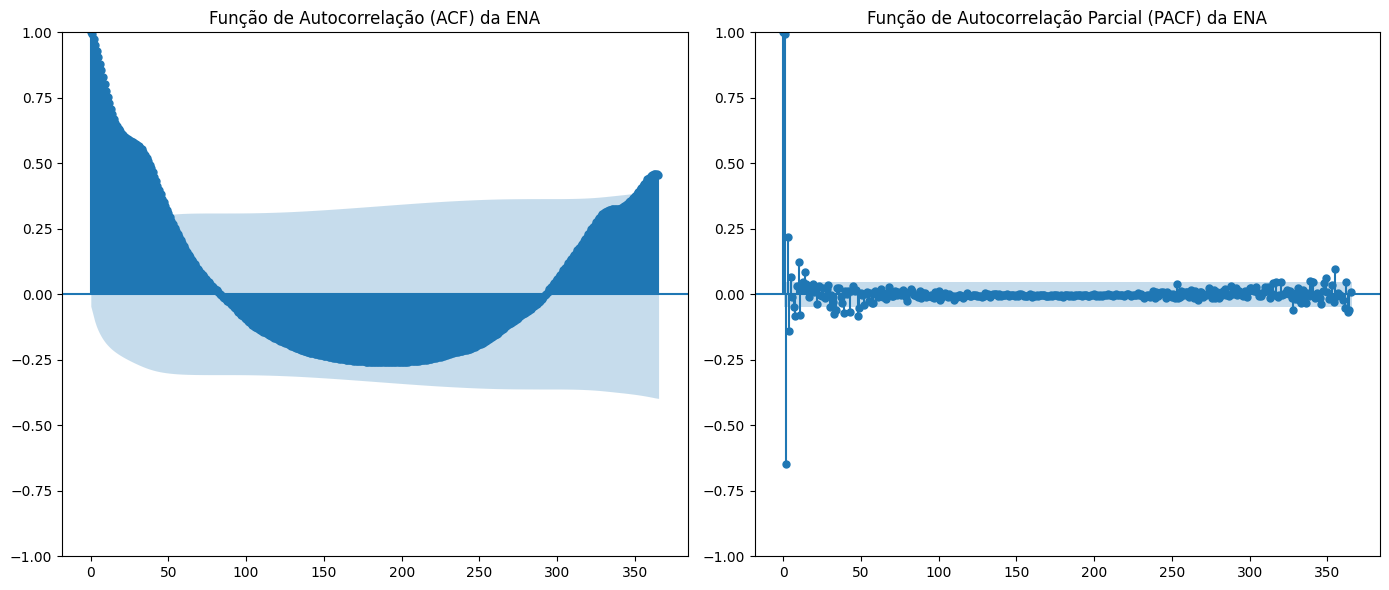

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/jyp3icmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/kgqkttqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47868', 'data', 'file=/tmp/tmp20qzy7c_/jyp3icmg.json', 'init=/tmp/tmp20qzy7c_/kgqkttqs.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_modelpt_9qgjp/prophet_model-20250925104942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 235.02 MWméd
Raiz do Erro Quadrático Médio (RMSE): 396.57 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.95%

Contexto: O valor médio real de ENA no período foi de 235.11 MWméd.
Um erro (MAE) de 235.02 representa aproximadamente 99.96% do valor médio.


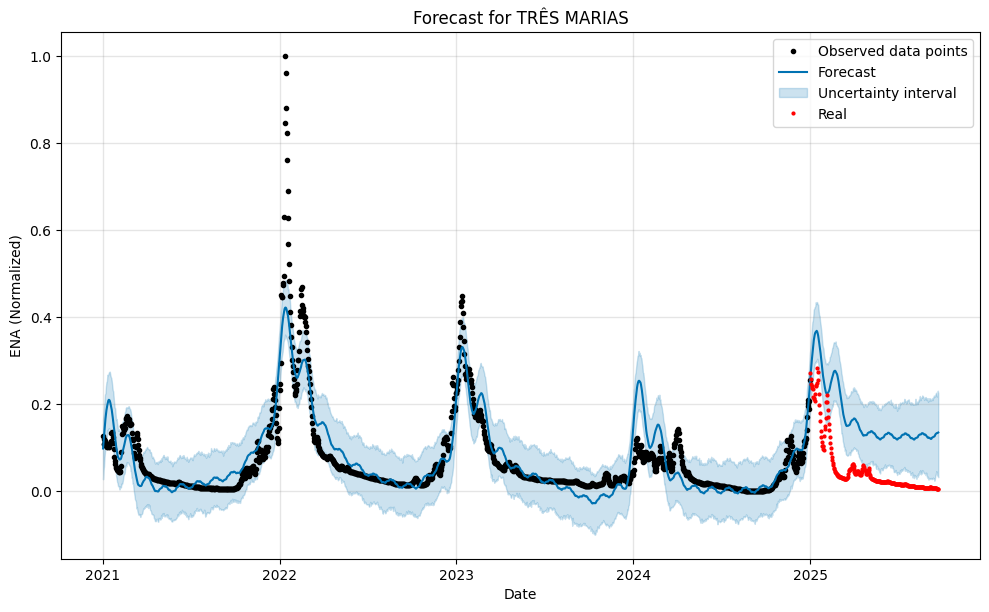

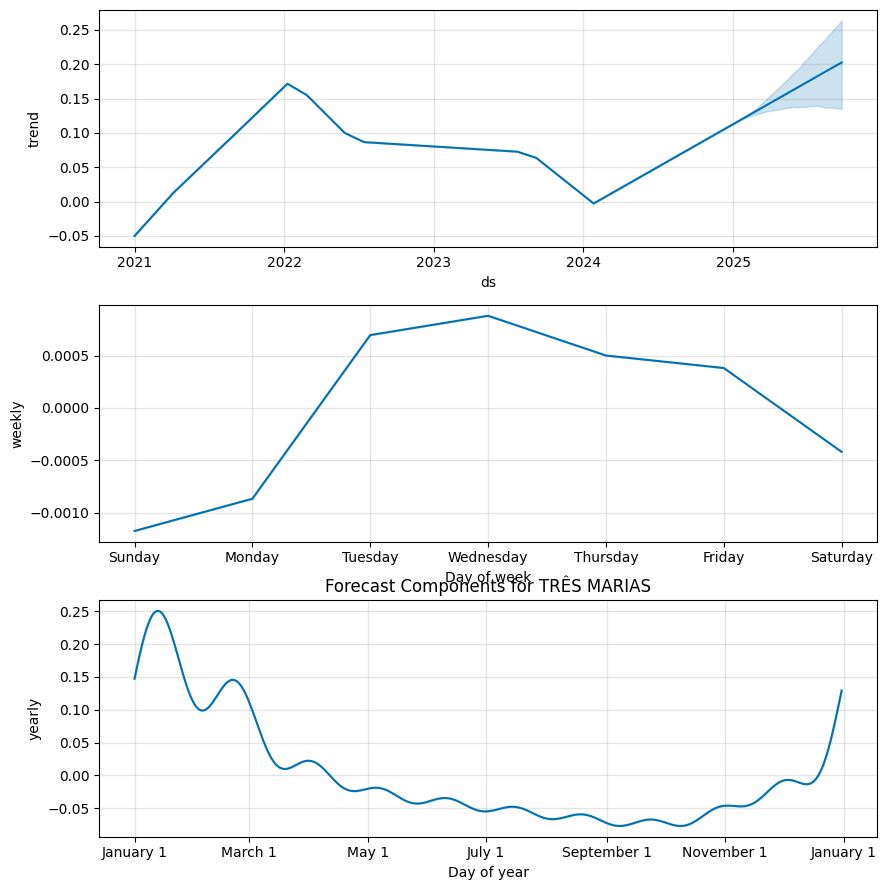

               ds    ena_di  ena_di_prev         rese
0             NaT       NaN     0.097658  TRÊS MARIAS
1             NaT       NaN     0.111657  TRÊS MARIAS
2             NaT       NaN     0.125259  TRÊS MARIAS
3             NaT       NaN     0.139284  TRÊS MARIAS
4             NaT       NaN     0.153731  TRÊS MARIAS
...           ...       ...          ...          ...
261431 2025-09-18  0.006631          NaN  TRÊS MARIAS
261586 2025-09-19  0.005432          NaN  TRÊS MARIAS
261741 2025-09-20  0.005469          NaN  TRÊS MARIAS
261896 2025-09-21  0.005121          NaN  TRÊS MARIAS
262051 2025-09-22  0.004948          NaN  TRÊS MARIAS

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0100 - val_loss: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0018 - val_loss: 6.5581e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 9.1154e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 7.5067e-04
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.0668e-04 - val_loss: 7.7632e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.9214e-04 - val_loss: 6.5774e-04
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.2687e-04 - val_loss: 5.8017e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 8.2532e-04 - val_loss: 6.2907e-04
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.7429e-04 - val_loss: 8.0479e-04
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.5980e-04 - val_loss: 5.6352e-04
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.4963e-04 - val_loss: 5.6824e-04
Epoch 

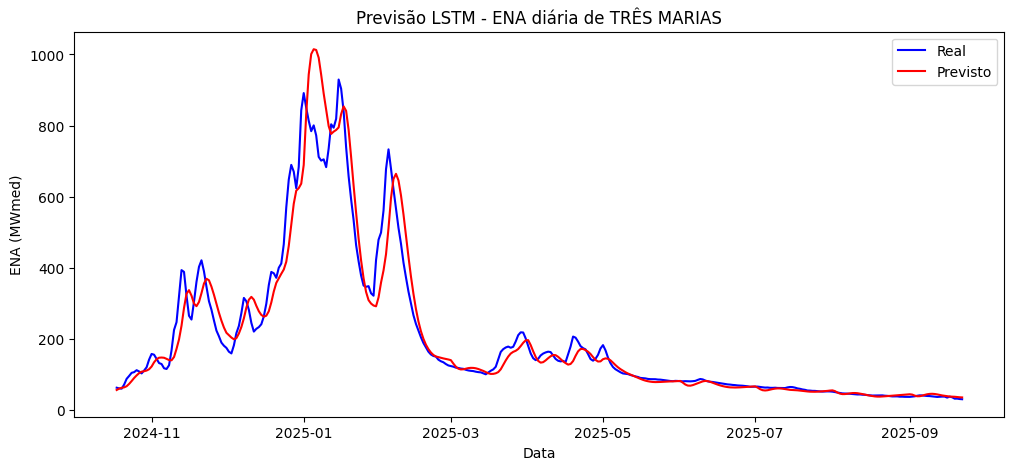

Reservatório: APOLONIO SALES


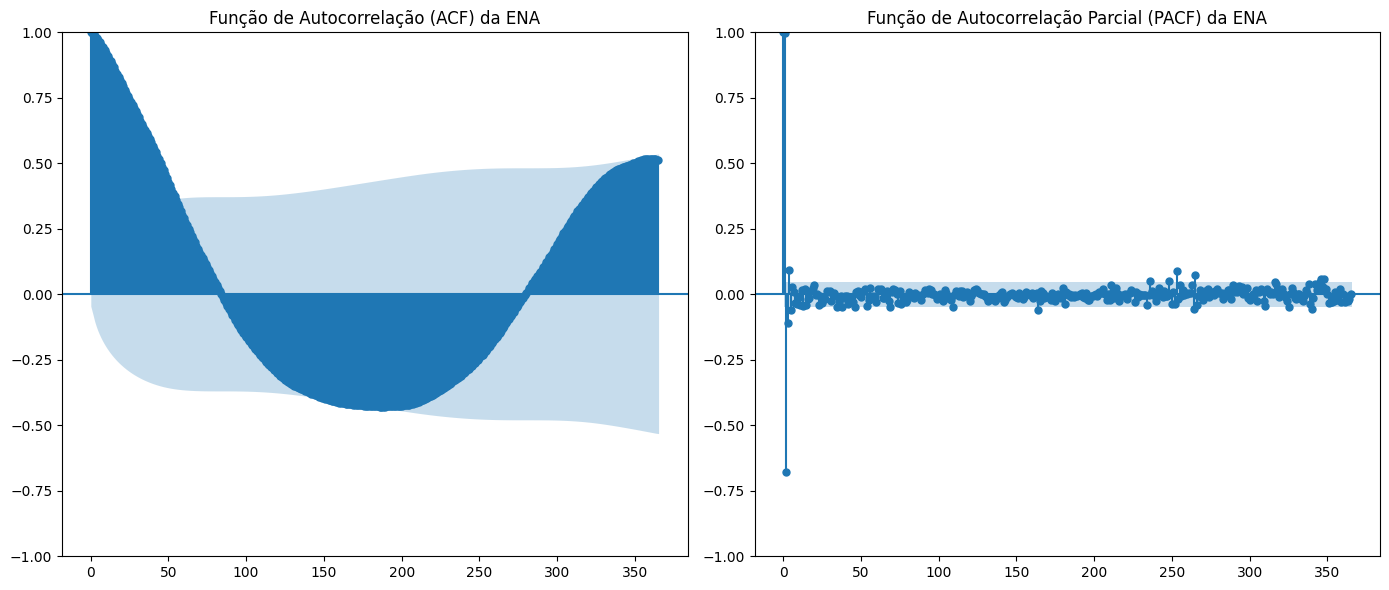

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/fz2cfp31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/5jf2akxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56218', 'data', 'file=/tmp/tmp20qzy7c_/fz2cfp31.json', 'init=/tmp/tmp20qzy7c_/5jf2akxs.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_model234ghw6r/prophet_model-20250925105043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 168.55 MWméd
Raiz do Erro Quadrático Médio (RMSE): 234.16 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.89%

Contexto: O valor médio real de ENA no período foi de 168.74 MWméd.
Um erro (MAE) de 168.55 representa aproximadamente 99.89% do valor médio.


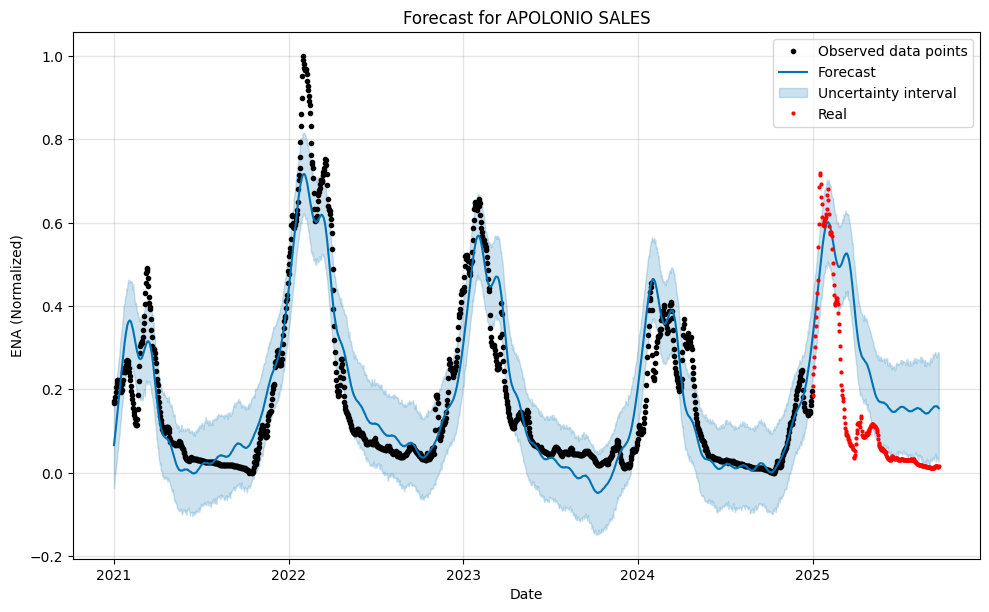

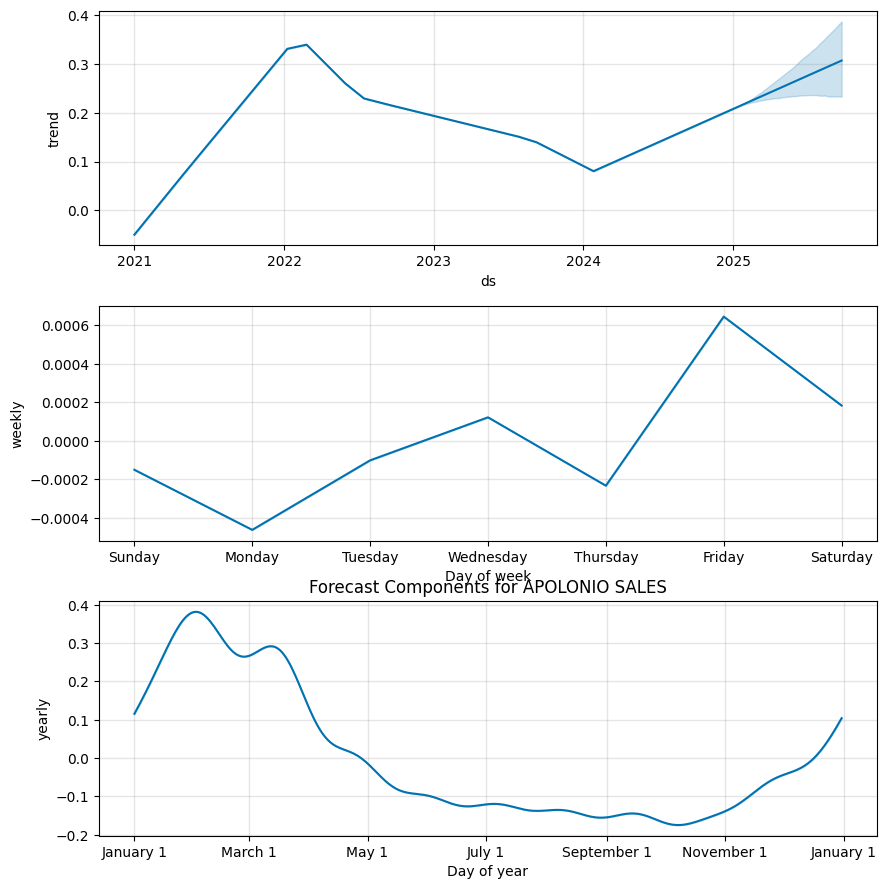

               ds    ena_di  ena_di_prev            rese
0             NaT       NaN     0.066360  APOLONIO SALES
1             NaT       NaN     0.076259  APOLONIO SALES
2             NaT       NaN     0.086440  APOLONIO SALES
3             NaT       NaN     0.096790  APOLONIO SALES
4             NaT       NaN     0.107960  APOLONIO SALES
...           ...       ...          ...             ...
261283 2025-09-18  0.016126          NaN  APOLONIO SALES
261438 2025-09-19  0.015384          NaN  APOLONIO SALES
261593 2025-09-20  0.013675          NaN  APOLONIO SALES
261748 2025-09-21  0.013366          NaN  APOLONIO SALES
261903 2025-09-22  0.015318          NaN  APOLONIO SALES

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0302 - val_loss: 0.0041
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.9603e-04 - val_loss: 0.0011
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012 - v

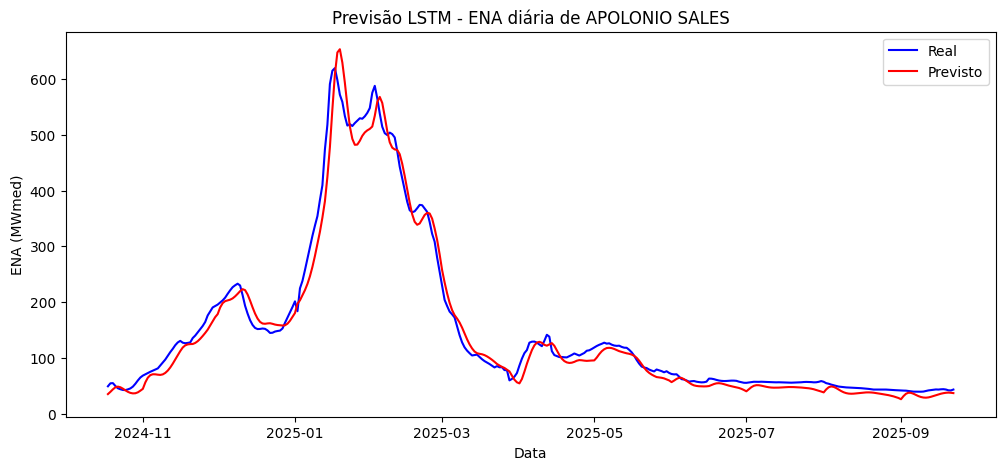

Reservatório: P. AFONSO 4


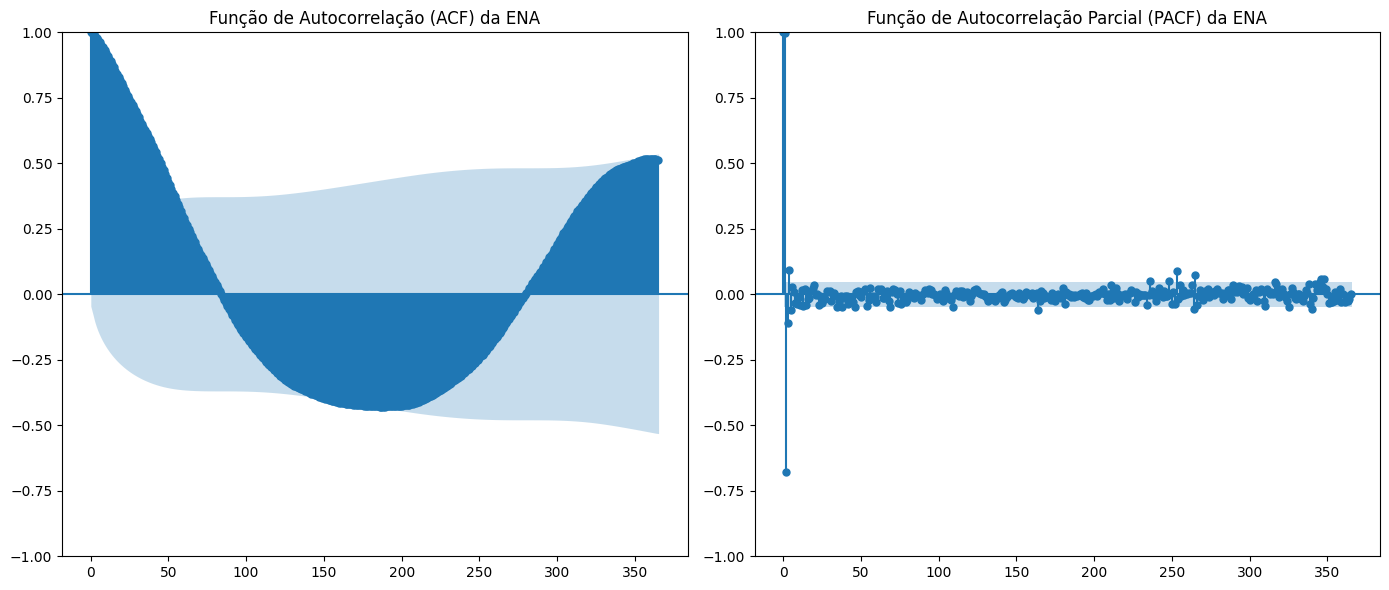

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/70m8a75j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20qzy7c_/_rooiqlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53574', 'data', 'file=/tmp/tmp20qzy7c_/70m8a75j.json', 'init=/tmp/tmp20qzy7c_/_rooiqlc.json', 'output', 'file=/tmp/tmp20qzy7c_/prophet_modelzvqdcr7r/prophet_model-20250925105147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Métricas de Avaliação do Modelo ###
Erro Médio Absoluto (MAE): 942.07 MWméd
Raiz do Erro Quadrático Médio (RMSE): 1308.71 MWméd
Erro Percentual Médio Absoluto (MAPE): 99.98%

Contexto: O valor médio real de ENA no período foi de 942.26 MWméd.
Um erro (MAE) de 942.07 representa aproximadamente 99.98% do valor médio.


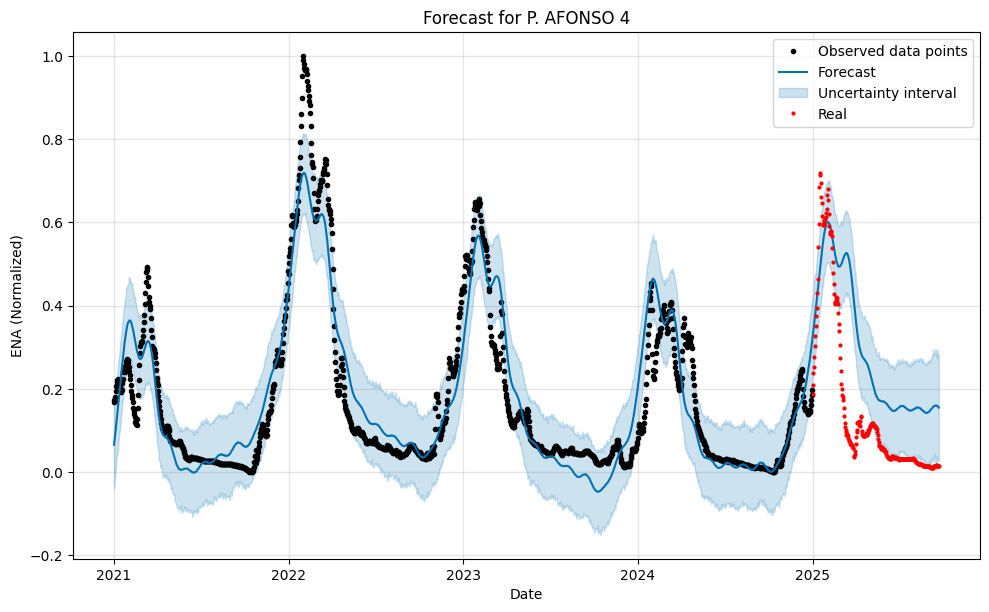

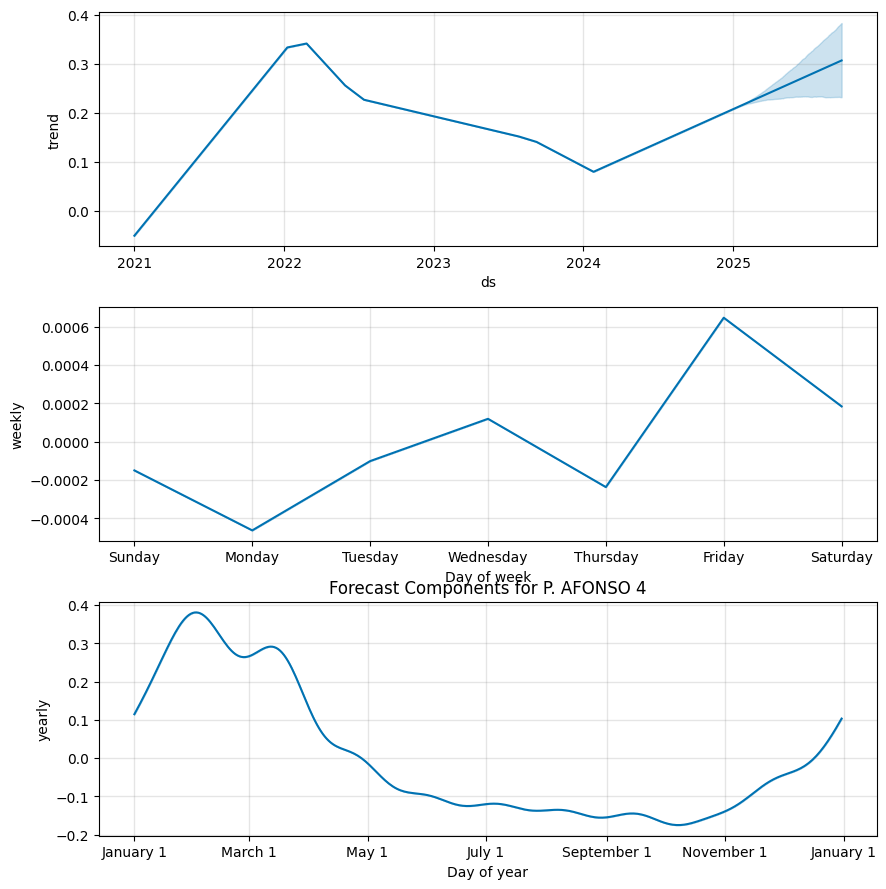

               ds    ena_di  ena_di_prev         rese
0             NaT       NaN     0.065472  P. AFONSO 4
1             NaT       NaN     0.075366  P. AFONSO 4
2             NaT       NaN     0.085542  P. AFONSO 4
3             NaT       NaN     0.095888  P. AFONSO 4
4             NaT       NaN     0.107053  P. AFONSO 4
...           ...       ...          ...          ...
261376 2025-09-18  0.016127          NaN  P. AFONSO 4
261531 2025-09-19  0.015383          NaN  P. AFONSO 4
261686 2025-09-20  0.013675          NaN  P. AFONSO 4
261841 2025-09-21  0.013365          NaN  P. AFONSO 4
261996 2025-09-22  0.015318          NaN  P. AFONSO 4

[1991 rows x 4 columns]
Shape X: (1696, 30, 4)
Shape y: (1696,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0243 - val_loss: 0.0049
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.0204e-04 - v

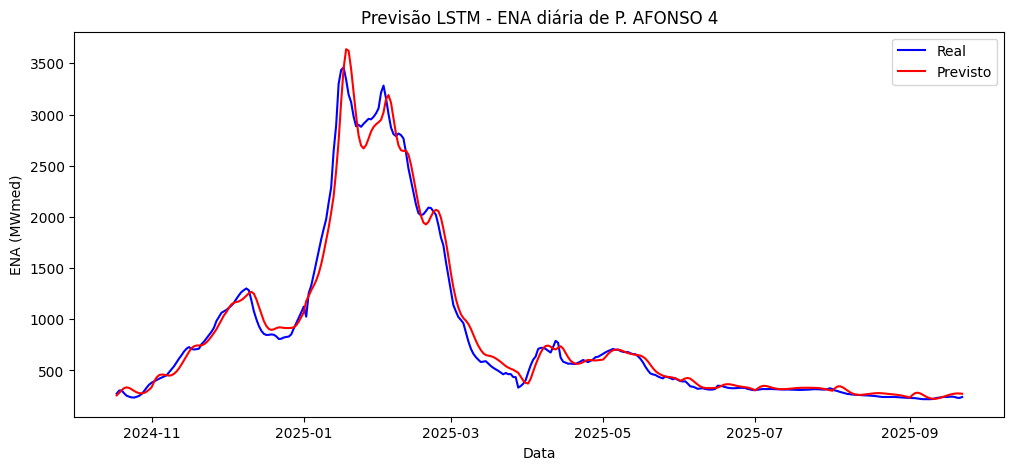

In [ ]:
ena_res = merge_ena_di_reservatorios(resorce_ena_di_interval, reservatorios)
reservatorios_sao_francisco = {
    169: {"name": "SOBRADINHO", "id": "SFSOBR"},
    174: {"name": "P. AFONSO 1,2,3", "id": "SFP123"},
    172: {"name": "LUIZ GONZAGA", "id": "SFLGON"},
    178: {"name": "XINGO", "id": "SFXING"},
    156: {"name": "TRÊS MARIAS", "id": "SFTMAR"},
    173: {"name": "APOLONIO SALES", "id": "SFMOXO"},
    175: {"name": "P. AFONSO 4", "id": "SFPAF4"}
}


for rese in reservatorios_sao_francisco:
  print(f'Reservatório: {reservatorios_sao_francisco[rese]["name"]}')

  preparared_ena_res = prepare_ena_di_reservatorio(ena_res, rese)
  plot_acf_pacf(preparared_ena_res, 'y')
  rese_name = reservatorios_sao_francisco[rese]["name"]
  train_prophet_model(preparared_ena_res, rese_name)
  train_lstm_model(preparared_ena_res, rese_name)


Todos os dados previstos por ambos modelos são armazenos em formato csv, assim como os gráficos de teste para acompanhar a eficência do treinamento.